# 1. Parquet 만들기

In [37]:
import pandas as pd
import pyarrow.parquet as pq
from pyarrow import csv
import io
from PIL import Image, ImageDraw
import os
import glob
from tqdm import tqdm

In [72]:
def pwithti(txt, img_list) :
    #txt preprocess
    txt_dict = {} # number : caption
    img_dict = {} # number : img_path
    txt_list = txt.split('\n')
    for t in txt_list :
        try : 
            number = t.split('. ')[0]
            caption = t.split('. ')[1]
            txt_dict[int(number)] = caption
        except :
            pass
    for i in os.listdir(img_list) :
        number = i.split('_')[-1].replace('.jpg','')
        img_dict[int(number)] = i
        
    c_list = []
    i_list = []
    for j in range(len(img_dict)) :
        try :
            caption = txt_dict[j]
            img_path= img_dict[j]
            c_list.append(caption)
            i_list.append(img_path)
        except :
            pass
        
    return c_list, i_list

In [93]:
def match_captions(root) :
    tot_c = []
    tot_i = []
    txts = glob.glob(f'{root}/*.txt')
    folders = glob.glob(f'{root}/*/')
    for j in range(len(txts)) :
        with open(txts[j],'r') as f :
            txt = f.read()
            f.close()
        c,i = pwithti(txt, folders[j])
        i = list(map(lambda p : folders[j]+p, i))
        
        tot_c = tot_c+c
        tot_i = tot_i+i
    return tot_c, tot_i

def make_parquet(caps, imgs) :
    LENGTH = len(caps)
    img_info = []
   
    for i in tqdm(range(LENGTH)) :
        bytes_dict = {}
        with open(imgs[i],'rb') as f:
            im_b = f.read()
            f.close()
        bytes_dict['bytes'] = im_b
        bytes_dict['path'] = None
        img_info.append(bytes_dict)
        
    caption_df = pd.DataFrame({
        'image' : img_info,
        'text' : caps
    })
    return caption_df

In [99]:
# 실행코드
caps,imgs = match_captions('ghibli')
caps_df = make_parquet(caps,imgs)
caps_df.to_parquet('./ghibli_gnc.parquet', engine='pyarrow')

100%|████████████████████████████████████████████████████████████████████████████| 1980/1980 [00:01<00:00, 1744.32it/s]


# 2. Huggingface 올리기(.parquet)

In [3]:
# 데이터 가져오기
from datasets import load_dataset
dataset = load_dataset("HoneyTylenol/ghibli_gnc",split='train', use_auth_token=True)

Using custom data configuration HoneyTylenol--ghibli_gnc-5b5f9f8a38fc72a2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/HoneyTylenol___parquet/HoneyTylenol--ghibli_gnc-5b5f9f8a38fc72a2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [7]:
# json에 들어갈 정보확인하기 -> 이거 보고 dataset_infos.json 만들기
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': {'bytes': Value(dtype='binary', id=None), 'path': Value(dtype='null', id=None)}, 'text': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', config_name='HoneyTylenol--ghibli_gnc', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=108926673, num_examples=1980, dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/HoneyTylenol/ghibli_gnc/resolve/bab7644fbfd8ad22c802bd7088a8522a77f6d759/data/ghibli_gnc.parquet': {'num_bytes': 108814661, 'checksum': 'c4c1f04a19eb9cd5f32668c08fc5b8cf611d5dcc06f5f8c9a71cdb080b23918c'}}, download_size=108814661, post_processing_size=None, dataset_size=108926673, size_in_bytes=217741334)

# 3. Huggingface에 JSON까지 올리고 다시 LOAD 해서 확인

In [8]:
# 데이터 가져오기
from datasets import load_dataset
dataset = load_dataset("HoneyTylenol/ghibli_gnc",split='train', use_auth_token=True)
dataset[0]

Using custom data configuration ghibli_gnc-388bcf2ab4a68452


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/HoneyTylenol___parquet/ghibli_gnc-388bcf2ab4a68452/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'text': 'Anne, a praying red-haired girl, windows, curtain'}

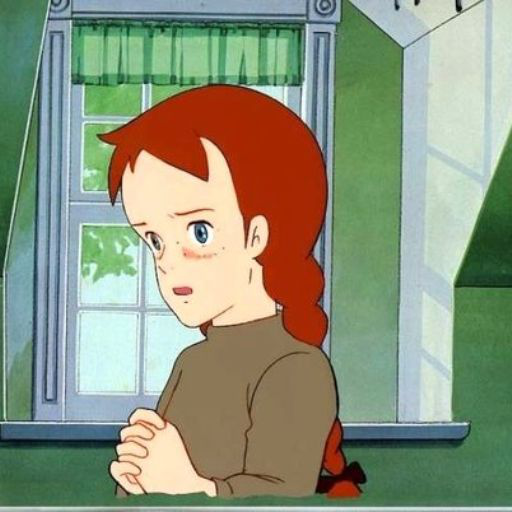

In [9]:
dataset[0]['image']

In [10]:
dataset[0]['text']

'Anne, a praying red-haired girl, windows, curtain'

# 4. Diffusion yaml 만들기  
- ./configs/stable-diffusion/*.yaml 만들면 됨
- step : 이미지 개수
- epoch : 이미지 전체개수를 1epoch으로 돌린 횟수.

### yaml 건드려야 할 params
- batch_size : 이거는 GPU 메모리 높으면 높아도됨. 40GB -> batch_size 2정도가 적당해요
- num_workers : 컴퓨터 cpu 코어수/2
- train-name : 
- n_gpus : gpu개수
- every_n_train_steps : train하고 모델 언제 저장할지(step기준)